In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import  Naive, AutoARIMA, AutoCES, AutoTheta, AutoETS
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datasetsforecast.losses import mae
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

In [22]:
warnings.filterwarnings("ignore")

In [23]:
tickers = ['BTC-USD', 'NVDA', 'IBM'] 
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1d')
df.head()

[*********************100%%**********************]  3 of 3 completed


Price          Adj Close                               Close              \
Ticker           BTC-USD         IBM      NVDA       BTC-USD         IBM   
Date                                                                       
2018-01-01  13657.200195         NaN       NaN  13657.200195         NaN   
2018-01-02  14982.099609  108.470901  4.930643  14982.099609  147.466537   
2018-01-03  15201.000000  111.452538  5.255147  15201.000000  151.520081   
2018-01-04  15599.200195  113.709877  5.282848  15599.200195  154.588913   
2018-01-05  17429.500000  114.265427  5.327617  17429.500000  155.344162   

Price                        High                                Low  \
Ticker         NVDA       BTC-USD         IBM     NVDA       BTC-USD   
Date                                                                   
2018-01-01      NaN  14112.200195         NaN      NaN  13154.700195   
2018-01-02  4.98375  15444.599609  148.001907  4.98750  13163.599609   
2018-01-03  5.31175  15572.799805  152.782028  5.34250  14844.500000   
2018-01-04  5.33975  15739.700195  155.181641  5.45125  14522.200195   
2018-01-05  5.38500  17705.199219  155.736145  5.42275  15202.799805   

Price                                    Open                       \
Ticker             IBM     NVDA       BTC-USD         IBM     NVDA   
Date                                                                 
2018-01-01         NaN      NaN  14112.200195         NaN      NaN   
2018-01-02  146.787766  4.86250  13625.000000  147.705551  4.89450   
2018-01-03  149.455063  5.09375  14978.200195  150.420654  5.10250   
2018-01-04  152.361374  5.31725  15270.700195  152.629059  5.39400   
2018-01-05  154.015289  5.27700  15477.200195  155.296371  5.35475   

Price            Volume                          
Ticker          BTC-USD        IBM         NVDA  
Date                                             
2018-01-01  10291200000        NaN          NaN  
2018-01-02  16846600192  4395815.0  355616000.0  
2018-01-03  16871900160  9875914.0  914704000.0  
2018-01-04  21783199744  7903785.0  583268000.0  
2018-01-05  23840899072  5434807.0  580124000.0

In [24]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel()
df = df.reset_index()
df.head()

Ticker,Date,BTC-USD,NVDA,IBM
0,2018-01-01,13657.200195,NaN,NaN
1,2018-01-02,14982.099609,4.930643,108.470901
2,2018-01-03,15201.000000,5.255147,111.452538
3,2018-01-04,15599.200195,5.282848,113.709877
4,2018-01-05,17429.500000,5.327617,114.265427


In [25]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices

,unique_id,ds,y
0,BTC-USD,2018-01-01,13657.200195
1,BTC-USD,2018-01-02,14982.099609
2,BTC-USD,2018-01-03,15201.000000
3,BTC-USD,2018-01-04,15599.200195
4,BTC-USD,2018-01-05,17429.500000
...,...,...,...
5470,IBM,2022-12-26,NaN
5471,IBM,2022-12-27,133.133942
5472,IBM,2022-12-28,130.890427
5473,IBM,2022-12-29,131.862610


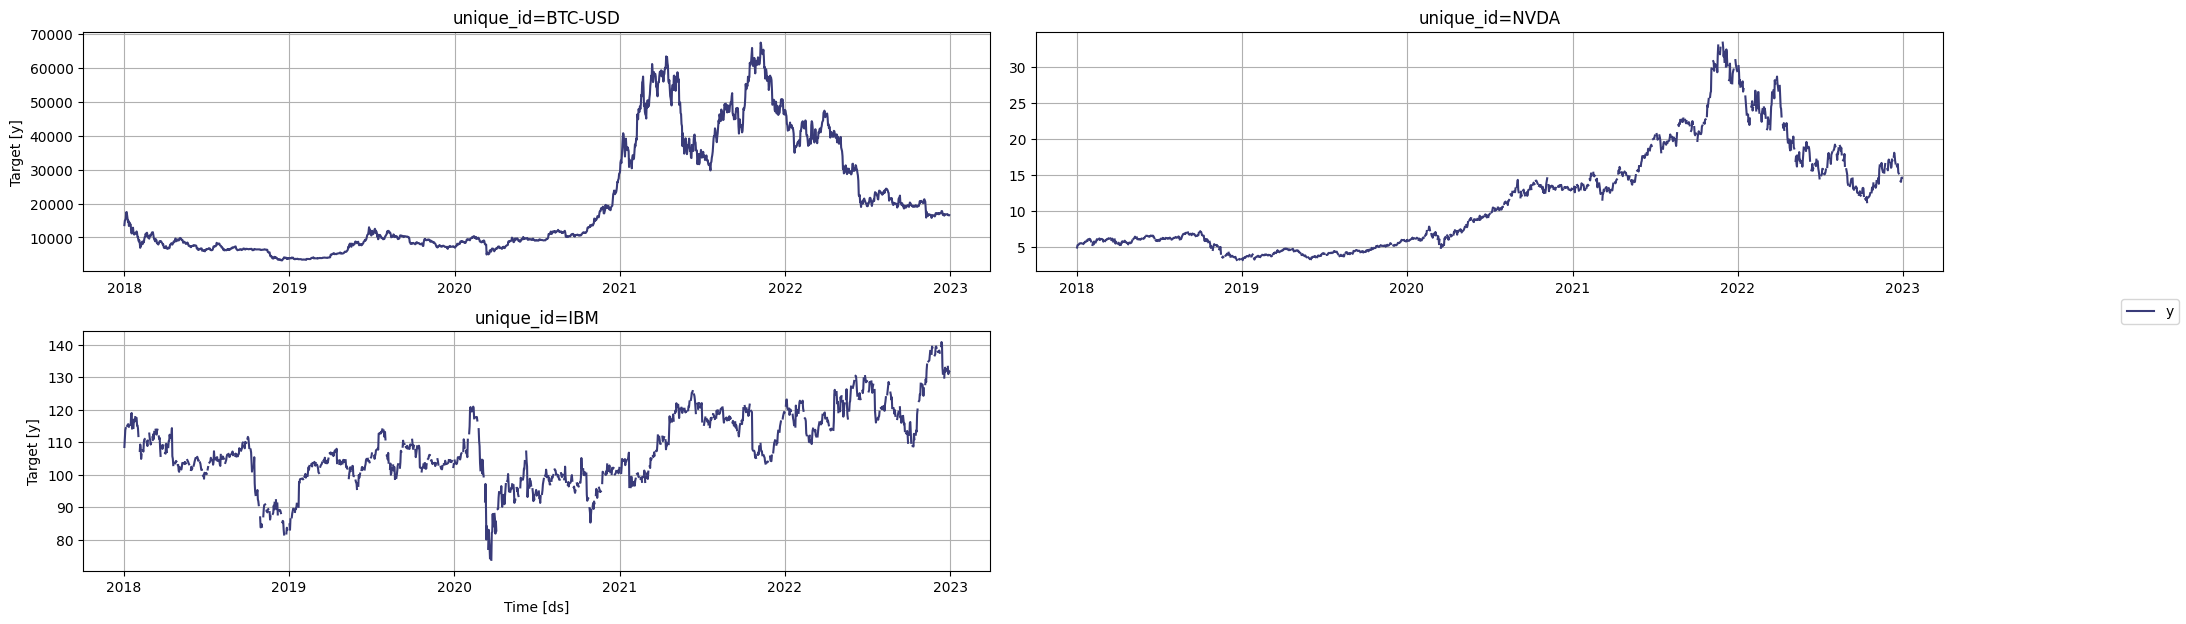

In [26]:
StatsForecast.plot(prices)

In [27]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns = returns.dropna(subset=['y'])
returns

,unique_id,ds,y
1,BTC-USD,2018-01-02,0.092589
2,BTC-USD,2018-01-03,0.014505
3,BTC-USD,2018-01-04,0.025858
4,BTC-USD,2018-01-05,0.110945
5,BTC-USD,2018-01-06,0.005578
...,...,...,...
5466,IBM,2022-12-22,-0.008904
5467,IBM,2022-12-23,0.005451
5472,IBM,2022-12-28,-0.016995
5473,IBM,2022-12-29,0.007400


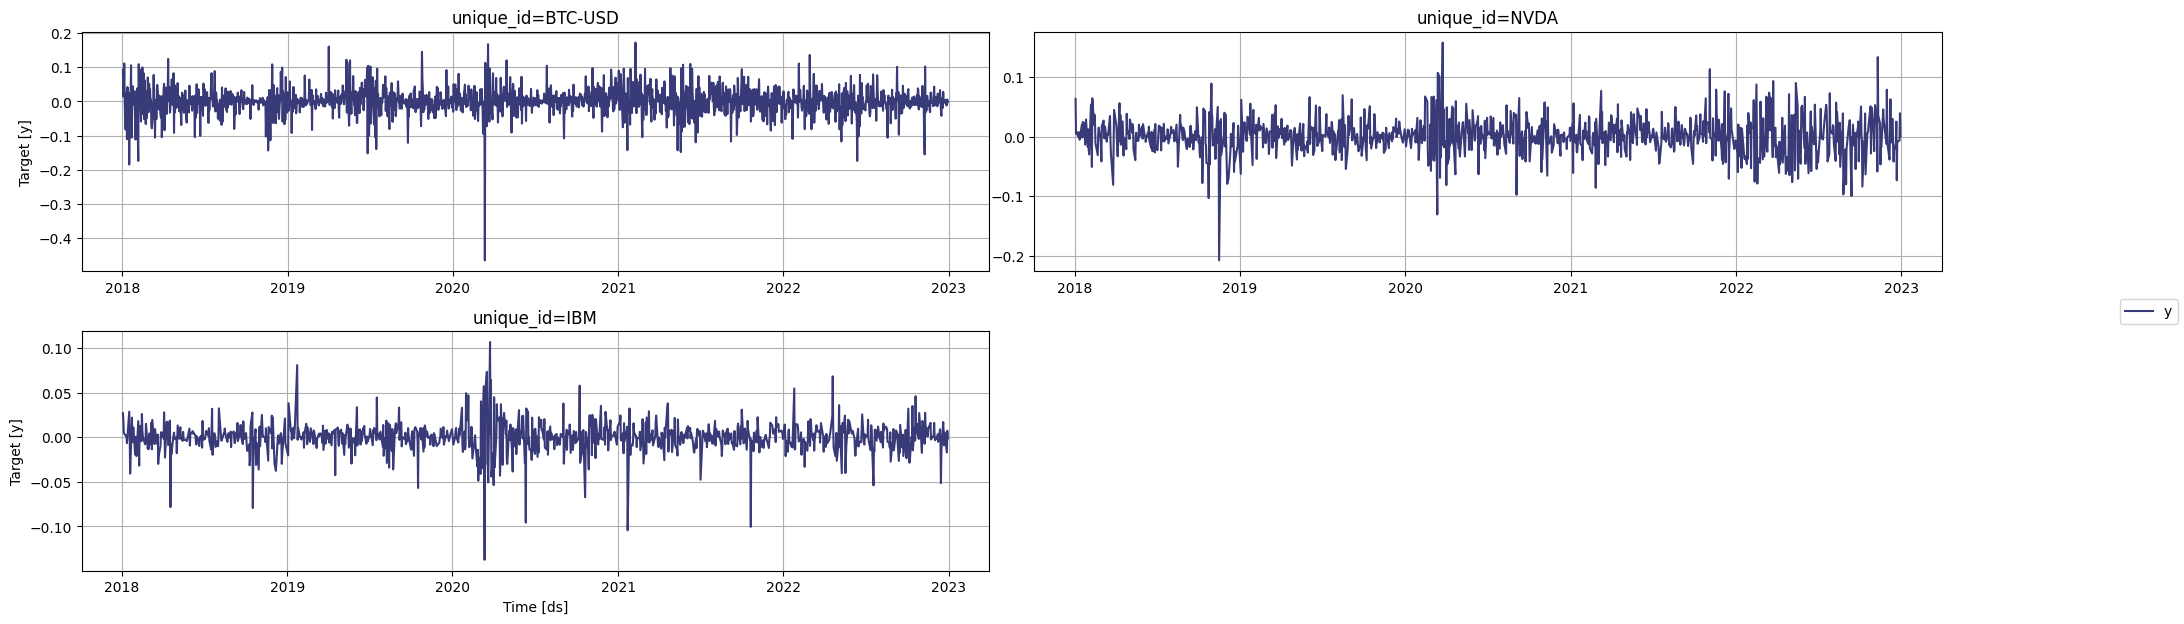

In [28]:
StatsForecast.plot(returns)

<Figure size 1500x2000 with 0 Axes>

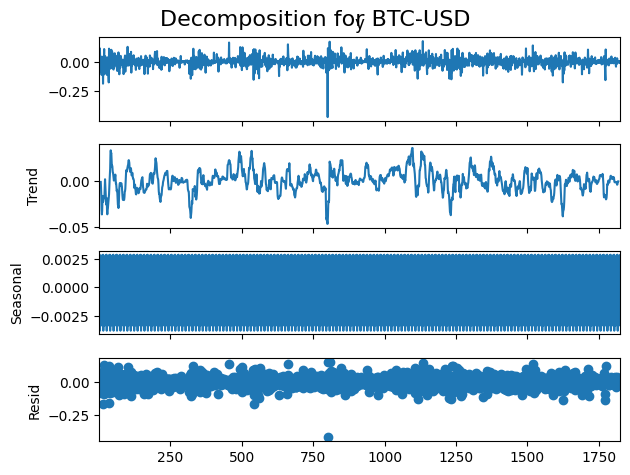

<Figure size 1500x2000 with 0 Axes>

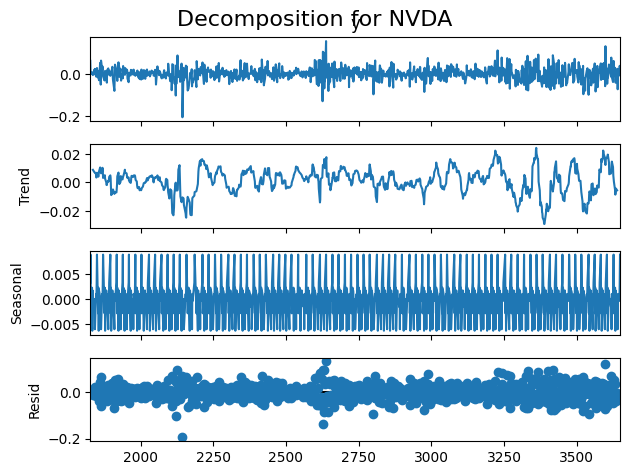

<Figure size 1500x2000 with 0 Axes>

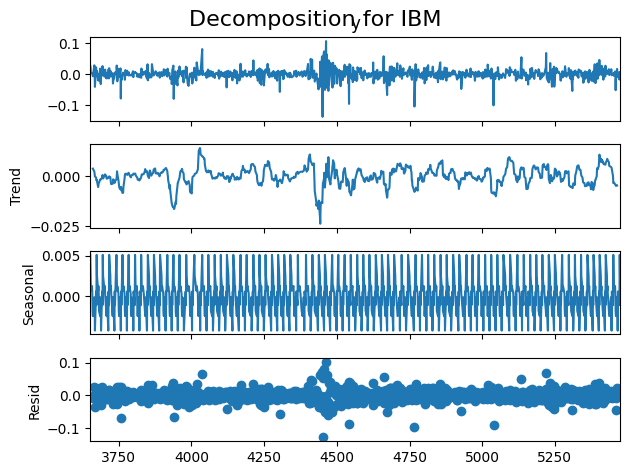

In [29]:
# Descomposición estacional
unique_ids = returns['unique_id'].unique()

for unique_id in unique_ids:
    series = returns[returns['unique_id'] == unique_id]
    
    # Asegurarse de que hay suficientes datos para la descomposición
    if len(series) >= 24:  # Al menos dos años de datos mensuales
        decomposition = seasonal_decompose(series['y'], model='additive', period=12)
        
        # Graficar
        plt.figure(figsize=(15, 20))
        decomposition.plot()
        plt.suptitle(f'Decomposition for {unique_id}', fontsize=16)
        plt.show()
    else:
        print(f"Not enough data to decompose for {unique_id}")

In [30]:
models = [Naive(), AutoETS(), AutoTheta(), AutoARIMA()]

#AutoCES no deja 

sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'D',
    n_jobs = -1
)
sf.fit()

StatsForecast(models=[Naive,AutoETS,AutoTheta,AutoARIMA])

Modelo: Naive
No residuals found for Naive
Modelo: AutoETS


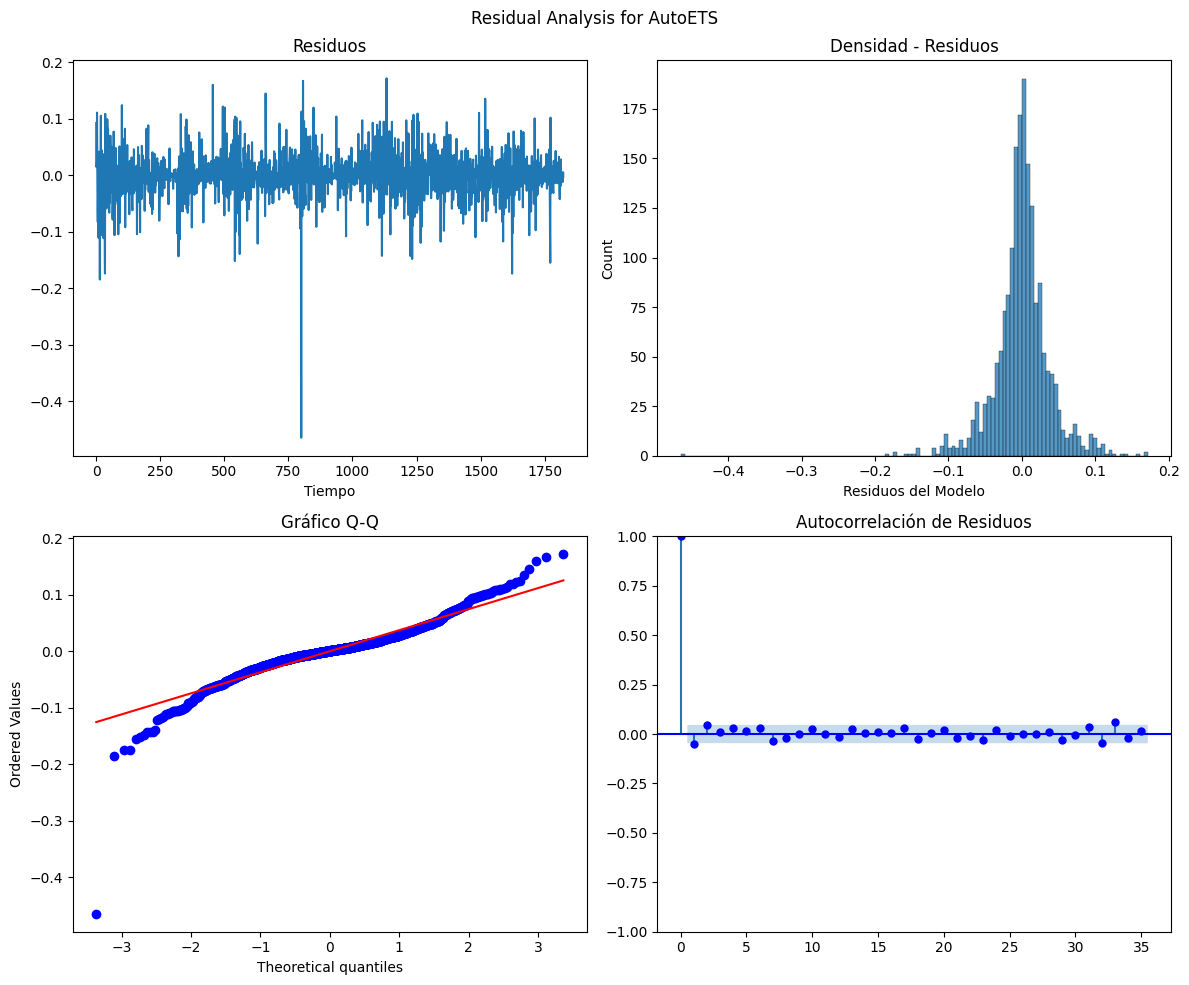

Modelo: AutoTheta


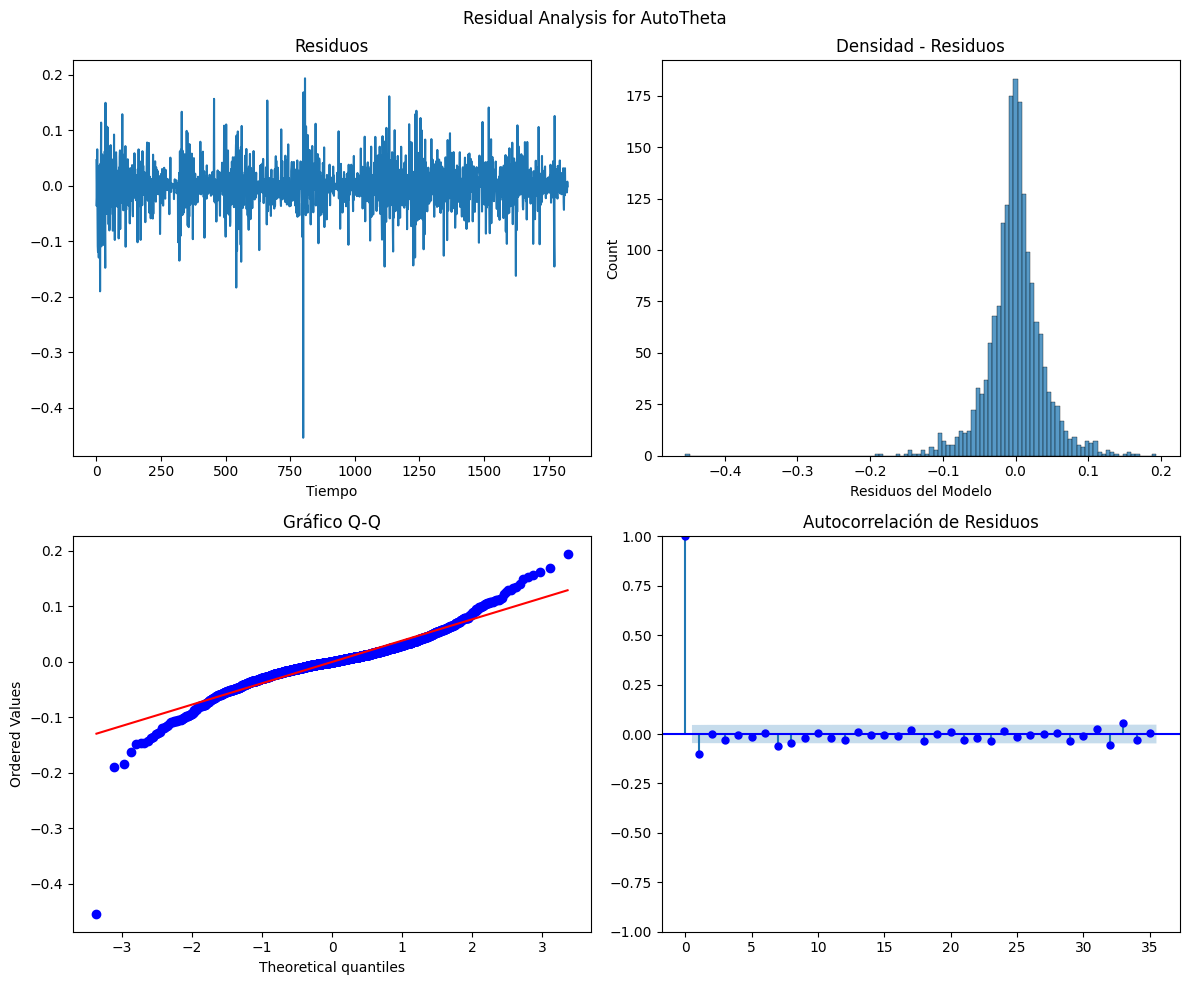

Modelo: AutoARIMA
(0, 2, 0, 0, 1, 0, 0)


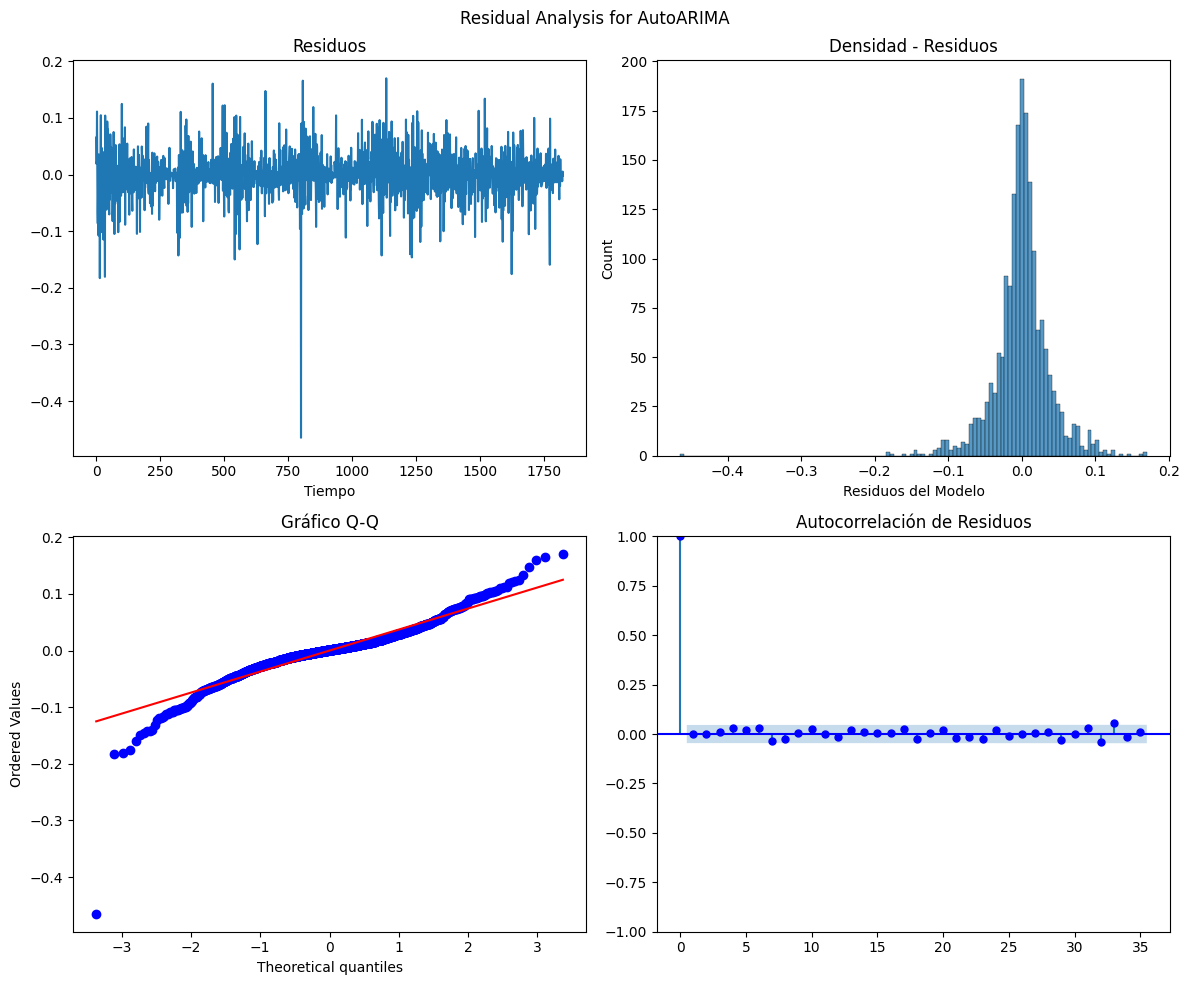

In [31]:
# Convertir sf.fitted_ a un diccionario
fitted_dict = {model_name: model_result for model_name, model_result in zip(models, sf.fitted_[0])}

# Iterar sobre los modelos ajustados y visualizar los residuos
for model in models:
    model_name = type(model).__name__
    model_result = fitted_dict[model]
    
    print(f"Modelo: {model_name}")

    # Verificar si el modelo tiene residuals
    if 'residuals' in model_result.model_:
        # Imprimir los componentes del modelo si están disponibles
        if 'arma' in model_result.model_:
            print(model_result.model_['arma'])

        # Residuales del modelo
        residual = pd.DataFrame(model_result.model_.get("residuals"), columns=["Residuos del Modelo"])

        # Visualización de los residuos
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

        # Residuales a lo largo del tiempo
        residual['Residuos del Modelo'].plot(ax=axs[0, 0])
        axs[0, 0].set_title("Residuos")
        axs[0, 0].set_xlabel('Tiempo')

        # Histograma de los residuos
        sns.histplot(residual['Residuos del Modelo'], ax=axs[0, 1])
        axs[0, 1].set_title("Densidad - Residuos")

        # Gráfico Q-Q
        stats.probplot(residual['Residuos del Modelo'], dist="norm", plot=axs[1, 0])
        axs[1, 0].set_title('Gráfico Q-Q')

        # ACF de los residuos
        plot_acf(residual['Residuos del Modelo'], lags=35, ax=axs[1, 1], color="blue")
        axs[1, 1].set_title("Autocorrelación de Residuos")

        plt.suptitle(f'Residual Analysis for {model_name}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No residuals found for {model_name}")

In [32]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

In [33]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,Naive,AutoETS,AutoTheta,AutoARIMA
0,BTC-USD,2022-12-19,2022-12-18,-0.019176,-0.002212,0.000101,-0.002025,3.343004e-04
1,BTC-USD,2022-12-20,2022-12-18,0.027989,-0.002212,0.000101,-0.002025,7.917105e-07
2,BTC-USD,2022-12-21,2022-12-18,-0.005265,-0.002212,0.000101,-0.002025,0.000000e+00
3,BTC-USD,2022-12-22,2022-12-21,0.000761,-0.005265,0.000102,-0.001037,1.300794e-03
4,BTC-USD,2022-12-23,2022-12-21,-0.001986,-0.005265,0.000102,-0.001037,-1.333075e-04


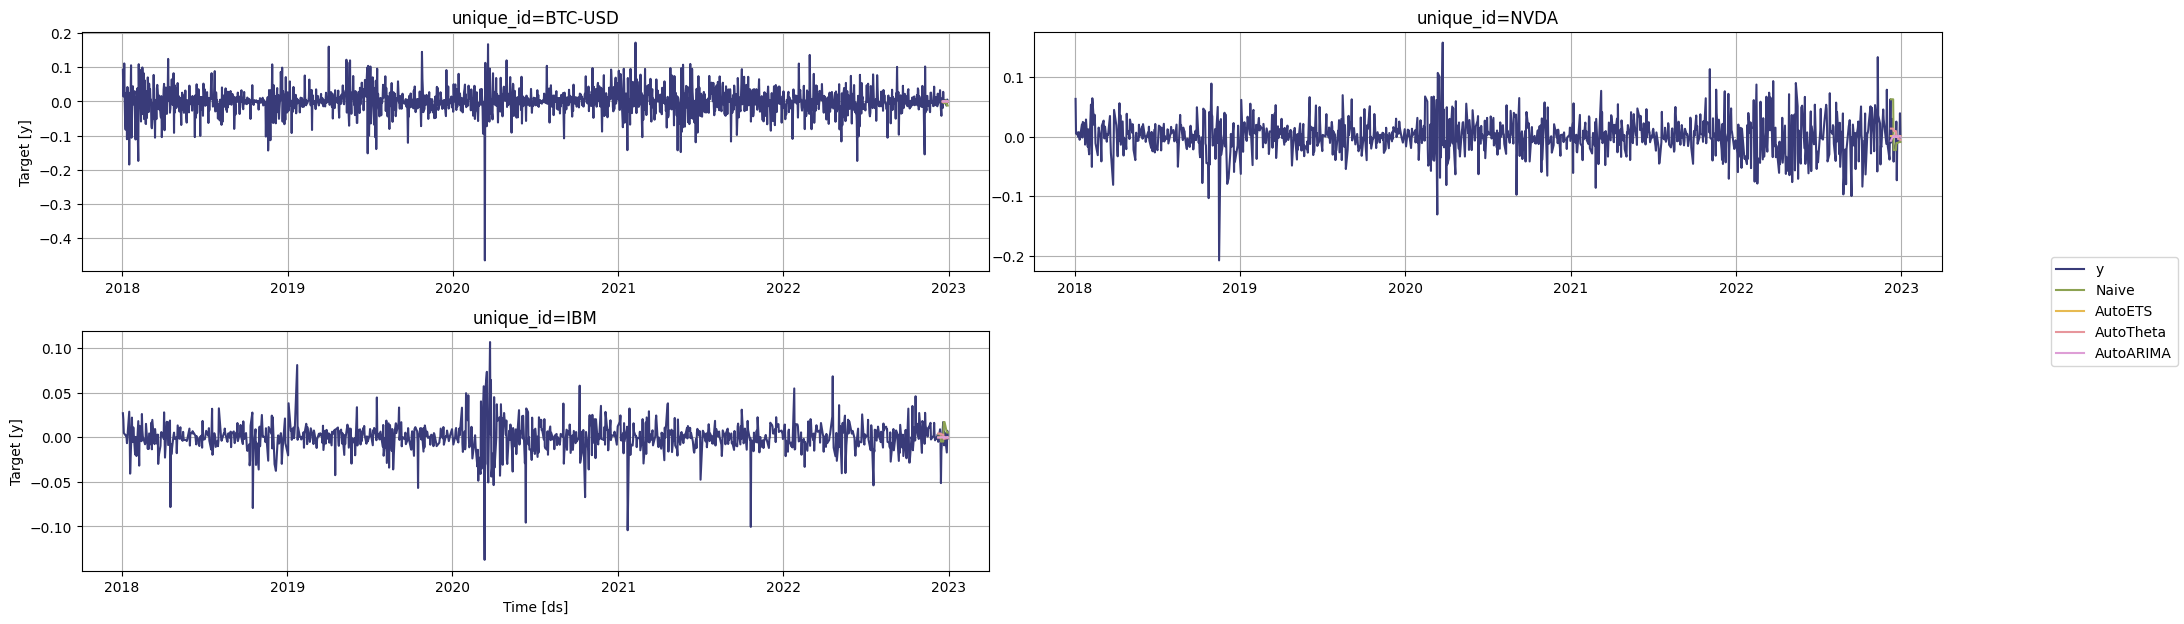

In [34]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [35]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)


mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae*100

,Naive,AutoETS,AutoTheta,AutoARIMA
unique_id,,,,
BTC-USD,0.975779,0.775879,0.754639,0.781548
IBM,1.513814,1.241557,1.308469,1.236710
NVDA,3.196114,2.474731,2.827692,2.386860
